In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from scipy.integrate import dblquad
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

from dataloader import FastTensorDataLoader

# Poisson Point Processes

## Data Generation

In [2]:
def generate_poisson_points(kappa, scale, region):
    """
    Generate a Poisson Point Process in a 2D region based on intensity function.
    
    Parameters:
    - kappa (torch.Tensor): The intensity parameter (scalar or vector).
    - scale (torch.Tensor): The scale parameter (scalar or vector).
    - region (tuple): The spatial domain as ((xmin, xmax), (ymin, ymax)).
    - num_samples (int): Number of candidate points to sample for rejection sampling.
    
    Returns:
    - points (numpy.ndarray): The simulated points of the PPP.
    """
    (xmin, xmax), (ymin, ymax) = region

    area = (xmax - xmin) * (ymax - ymin)
    max_intensity = kappa * area  # Maximum value of intensity
    num_samples = np.random.poisson(lam=max_intensity)[0]

    x_candidates = np.random.uniform(xmin, xmax, size=num_samples)
    y_candidates = np.random.uniform(ymin, ymax, size=num_samples)
    candidates = torch.tensor(np.stack([x_candidates, y_candidates], axis=1), dtype=torch.float32)
    
    squared_norm = torch.sum(candidates**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    
    uniform_samples = torch.rand(num_samples)  # Uniform samples for rejection
    acceptance_mask = uniform_samples < (intensity / kappa)
    
    accepted_points = candidates[acceptance_mask]
    return accepted_points.numpy()

In [286]:
kappa = torch.tensor([10000.0])
scale = torch.tensor([0.1])

region = ((-1, 1), (-1, 1))  # A square domain in 2D

In [287]:
num_samples = 10000
samples = []
x_test = None
for _ in range(num_samples):
    x_t = generate_poisson_points(kappa, scale, region)
    if x_test is None:
        x_test = x_t.copy()
    samples.append(torch.tensor(x_t))

In [288]:
X = pad_sequence(samples, batch_first=True, padding_value=0)
lengths = torch.tensor([len(s) for s in samples], dtype=torch.int64)

lengths_expanded = lengths.unsqueeze(-1).expand(-1, X.shape[1])
X = torch.cat((X, lengths_expanded.unsqueeze(-1)), dim=-1)

X_train = X[:100]
X_val = X[100:150]
loader_train = FastTensorDataLoader(X_train, batch_size=1000, shuffle=False)
loader_val = FastTensorDataLoader(X_val, batch_size=1000, shuffle=False)

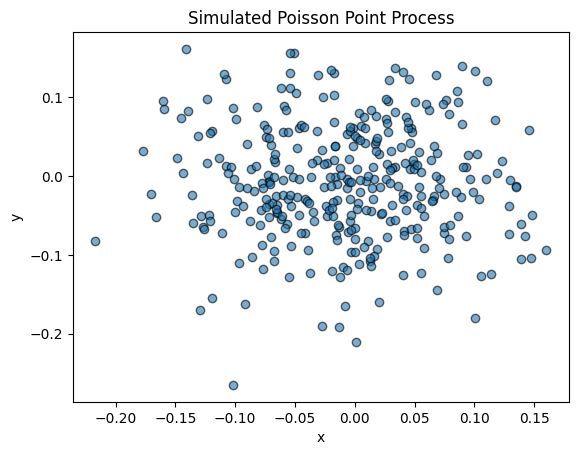

In [289]:
plt.scatter(x_test[:, 0], x_test[:, 1], alpha=0.6, edgecolor='k')
plt.title("Simulated Poisson Point Process")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Optimization function

In [290]:
def optimize_theta(loader_train, nn_model, num_epochs=1000, learning_rate=1e-3):
    """
    Optimizes the model parameters.

    Args:
        loader_train (DataLoader): DataLoader for training data.
        nn_model (callable): Function that creates the neural network model.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.

    Returns:
        tuple: (trained model, losses)
    """
    model = nn_model()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    losses, real_losses = [], []
    estimated_scale = []

    for epoch in range(num_epochs):
        for X_batch in loader_train:
            optimizer.zero_grad()

            loss, real_loss = model.loss(X_batch[0])

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            real_losses.append(real_loss.item())
            estimated_scale.append(model.scale.detach().numpy().copy())
            
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses, real_losses, estimated_scale


## Poisson Model

In [291]:
class Poisson(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(123)
        self.scale = nn.Parameter(torch.tensor([torch.abs(torch.randn(1))], dtype=torch.float32))

    def forward(self, x):
        squared_norm = torch.sum(x**2, dim=-1)
        return - squared_norm / self.scale**2

    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi
    
    def poisson_psi(self, x):
        return -2*x/self.scale**2
    
    def J(self, x_t, lengths):
        max_length = lengths.max()
        psi_x = self.poisson_psi(x_t)  

        norm_squared = (psi_x ** 2).sum(dim=-1) 

        divergence = -2 / self.scale**2 * x_t.shape[-1]
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = divergence*mask

        J_value = divergence + 0.5 * norm_squared
        J_value = J_value.sum(dim=-1) / lengths

        return J_value.mean()

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch
 
        psi_x = self.compute_psi(x_t)
        psi_x_real = self.poisson_psi(x_t)

        if not torch.allclose(psi_x, psi_x_real, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {psi_x} \
                is different from the analytical solution {psi_x_real}"
                )
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions

        # padded values give none zero divergence -> mask 
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        divergence = divergence * mask
        total_loss = 0.5 * norm_squared + divergence
        J = self.J(x_t, lengths)
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension
        if not torch.allclose(total_loss.mean(), J, atol=1e-4):
            raise ValueError(
                f"Calculated psi value {total_loss.mean()} \
                is different from the analytical solution {J}"
                )
        
        return total_loss.mean(), J

### Batch processing

In [292]:
start_time = time.time()
epochs = 100
model, losses, real_losses, estimated_scale = optimize_theta(
    loader_train, Poisson, num_epochs=epochs, learning_rate=1e-2,
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution Time: {elapsed_time:.2f} seconds")

Epoch 0/100, Loss: -192.02671813964844
Epoch 1/100, Loss: -199.31761169433594
Epoch 2/100, Loss: -186.7117919921875
Epoch 3/100, Loss: -186.7117919921875
Epoch 4/100, Loss: -197.44931030273438
Epoch 5/100, Loss: -198.98025512695312
Epoch 6/100, Loss: -198.98025512695312
Epoch 7/100, Loss: -199.35882568359375
Epoch 8/100, Loss: -199.35882568359375
Epoch 9/100, Loss: -199.4114227294922
Epoch 10/100, Loss: -199.4114227294922
Epoch 11/100, Loss: -199.45059204101562
Epoch 12/100, Loss: -199.45059204101562
Epoch 13/100, Loss: -199.44668579101562
Epoch 14/100, Loss: -199.44668579101562
Epoch 15/100, Loss: -199.45265197753906
Epoch 16/100, Loss: -199.44920349121094
Epoch 17/100, Loss: -199.44920349121094
Epoch 18/100, Loss: -199.45237731933594
Epoch 19/100, Loss: -199.45237731933594
Epoch 20/100, Loss: -199.45237731933594
Epoch 21/100, Loss: -199.45291137695312
Epoch 22/100, Loss: -199.4521484375
Epoch 23/100, Loss: -199.4521484375
Epoch 24/100, Loss: -199.45269775390625
Epoch 25/100, Loss: -1

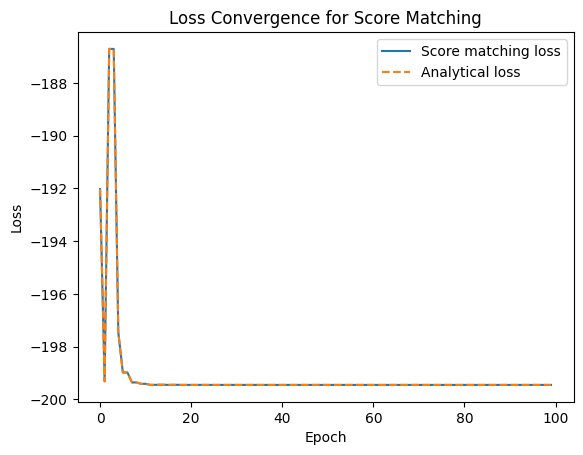

In [293]:
plt.plot(losses, label="Score matching loss")
plt.plot(real_losses, linestyle='--', label="Analytical loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()


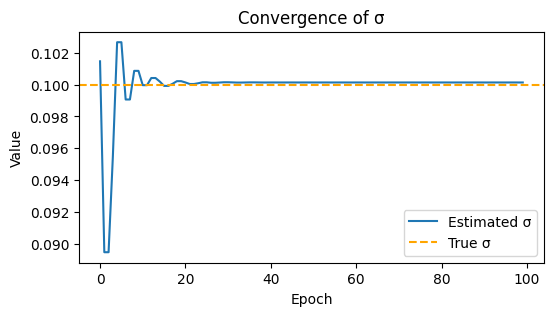

In [294]:
plt.figure(figsize=(6, 3))
plt.plot(estimated_scale, label="Estimated σ")
plt.axhline(scale, color='orange', linestyle='--', label="True σ")
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Convergence of σ')
plt.show()

In [295]:
print("Estimated scale:", model.scale)
print("True scale:", scale)

Estimated scale: Parameter containing:
tensor([0.1001], requires_grad=True)
True scale: tensor([0.1000])


### Kappa Inference

In [296]:
def infer_kappa(x_t, sigma, region):
    """
    Infers the parameter kappa for the Poisson Point Process intensity function
    given the data x_t and the known scale parameter sigma.
    
    Args:
    - x_t: numpy array of shape (n, d), where n is the number of data points and d is the dimension of the data.
    - sigma: the known scale parameter (positive real number).
    
    Returns:
    - kappa: the inferred scaling factor for the intensity function.
    """
    (a1, b1), (a2, b2) = region
    n = len(x_t)
    
    def integrand(x0, x1, sigma):
        return np.exp(-(x0**2 + x1**2) / sigma**2)

    integral_result, _ = dblquad(integrand, a1, b1, lambda x0: a2, lambda x0: b2, args=(sigma,))
    
    kappa = n / integral_result
    return kappa

In [297]:
kappa = infer_kappa(x_t, model.scale.detach().numpy(), region)
print(f"Inferred kappa: {kappa}")

Inferred kappa: 10316.783161744275


## Neural Network Poisson Model


In [298]:
def optimize_theta_nn(loader_train, nn_model, num_epochs=1000, learning_rate=1e-3):
    """
    Optimizes the model parameters.

    Args:
        loader_train (DataLoader): DataLoader for training data.
        nn_model (callable): Function that creates the neural network model.
        num_epochs (int): Number of training epochs.
        learning_rate (float): Learning rate.

    Returns:
        tuple: (trained model, losses)
    """
    model = nn_model()
    optimizer = torch.optim.Rprop(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(num_epochs):
        for X_batch in loader_train:
            optimizer.zero_grad()

            loss = model.loss(X_batch[0])

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            
            print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item()}")

    return model, losses


In [306]:
class Poisson_NN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10, output_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        intensity = torch.sigmoid(self.fc2(x))
        return torch.log(intensity)
    
    def compute_psi(self, x):
        x.requires_grad_()
        nn_output = self.forward(x)
        psi = torch.autograd.grad(nn_output, x, grad_outputs=torch.ones_like(nn_output), create_graph=True)[0]
        return psi

    def loss(self, points):
        lengths = points[:, 0, -1].to(dtype=torch.int64)
        max_length = lengths.max()
        x_t = points[:, :max_length, :-1]  # Pad to max length in batch
 
        psi_x = self.compute_psi(x_t)
        norm_squared = (psi_x ** 2).sum(dim=-1)  # Sum across all dimensions

        # padded values give none zero divergence -> mask 
        mask = torch.arange(max_length, device=x_t.device).unsqueeze(0) < lengths.unsqueeze(1)
        divergence = 0
        for i in range(x_t.shape[-1]):  # Iterate over the features of x
            gradient = torch.autograd.grad(psi_x[..., i].sum(), x_t, retain_graph=True, create_graph=True)[0]
            divergence += gradient[..., i]  # Sum over each feature dimension
        
        divergence = divergence * mask
        total_loss = 0.5 * norm_squared + divergence
        total_loss = total_loss.sum(dim=-1)/lengths  # Sum over the time dimension
        
        return total_loss.mean()

In [307]:
start_time = time.time()
epochs = 1000
model, losses = optimize_theta_nn(
    loader_train, Poisson_NN, num_epochs=epochs, learning_rate=1e-3,
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution Time: {elapsed_time:.2f} seconds")

Epoch 0/1000, Loss: -0.0028274550568312407
Epoch 1/1000, Loss: -0.00296163372695446
Epoch 2/1000, Loss: -0.003123505972325802
Epoch 3/1000, Loss: -0.0033190003596246243
Epoch 4/1000, Loss: -0.003555418225005269
Epoch 5/1000, Loss: -0.003841790836304426
Epoch 6/1000, Loss: -0.004189381841570139
Epoch 7/1000, Loss: -0.004612344782799482
Epoch 8/1000, Loss: -0.005128569435328245
Epoch 9/1000, Loss: -0.005760946776717901
Epoch 10/1000, Loss: -0.006539120804518461
Epoch 11/1000, Loss: -0.007502030115574598
Epoch 12/1000, Loss: -0.008701651357114315
Epoch 13/1000, Loss: -0.010208657942712307
Epoch 14/1000, Loss: -0.01212362665683031
Epoch 15/1000, Loss: -0.01458829641342163
Epoch 16/1000, Loss: -0.01782059110701084
Epoch 17/1000, Loss: -0.02214190736413002
Epoch 18/1000, Loss: -0.028074083849787712
Epoch 19/1000, Loss: -0.036419015377759933
Epoch 20/1000, Loss: -0.04839928448200226
Epoch 21/1000, Loss: -0.06592437624931335
Epoch 22/1000, Loss: -0.09199915081262589
Epoch 23/1000, Loss: -0.131

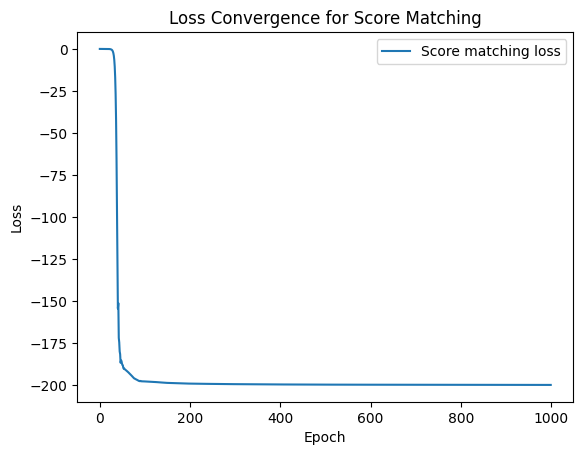

In [308]:
plt.plot(losses, label="Score matching loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Convergence for Score Matching')
plt.legend()
plt.show()


In [302]:
def compute_intensity(points, kappa, scale):
    squared_norm = torch.sum(points**2, dim=-1)
    intensity = kappa * torch.exp(-squared_norm / scale**2)
    return intensity

In [303]:
def calculate_mean_intensity(samples, kappa, scale):
    total_intensity = 0
    total_points = 0
    
    for sample in samples:
        # Compute intensity for each point in the sample
        intensities = compute_intensity(sample, kappa, scale)
        total_intensity += intensities.sum()
        total_points += len(sample)
    
    # Average intensity per sample
    mean_intensity = total_intensity / total_points
    return mean_intensity

In [304]:
intensity = calculate_mean_intensity(samples, kappa, scale)

In [305]:
print("Estimated intensity:", torch.mean(model(X_val[0][:,:2])))
print("True intensity:", intensity)

Estimated intensity: tensor(0.6915, grad_fn=<MeanBackward0>)
True intensity: tensor(5157.7329)


In [ ]:
class InhomPoissonNLL(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=30, output_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        intensity = self.fc2(x)
        return torch.exp(intensity)

    def loss(self, points):
        nll = 0.0
        x_grid = torch.linspace(x_min, x_max, steps=100)
        y_grid = torch.linspace(y_min, y_max, steps=100)
        
        xx, yy = torch.meshgrid(x_grid, y_grid)
        partition = torch.trapz(torch.trapz(self.intensity, dx=0.01), dx=0.01)
        for point in points:
            length = int(point[0, -1])
            x, y = point[:length, 0], point[:length, 1]
            log_likelihood = torch.sum(torch.log(self.intensity))
            
            # Add to the total NLL
            nll += log_likelihood - partition
        
        return -nll 

In [161]:
start_time = time.time()
epochs = 1000
model, losses = optimize_theta_nn(
    loader_train, InhomPoissonNLL, num_epochs=epochs, learning_rate=1e-3,
)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Execution Time: {elapsed_time:.2f} seconds")

IndexError: Dimension specified as -1 but tensor has no dimensions